In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, Mamba2ForCausalLM, Mamba2Config
from torch.utils.data import Dataset
import pickle
import torch
import transformers
transformers.logging.set_verbosity_info()
import logging
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only GPU 0

/home/leon/tesis/spanish-legal-ir/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LegalDataset(Dataset):
    def __init__(self, pickle_file_path, split="train", train_ratio=0.95):
        """
        Initialize the dataset with pre-tokenized data from a pickle file.
        :param pickle_file_path: Path to the pickle file containing pre-tokenized data.
        :param split: "train" or "val" to specify the dataset split.
        :param train_ratio: Ratio of the dataset to use for training (default: 80%).
        """
        # Load pre-tokenized data from the pickle file
        with open(pickle_file_path, "rb") as f:
            pretokenized_data = pickle.load(f)
        
        # Split into train and validation
        train_size = int(len(pretokenized_data) * train_ratio)
        if split == "train":
            self.pretokenized_data = pretokenized_data[:train_size]
        elif split == "val":
            self.pretokenized_data = pretokenized_data[train_size:]
        else:
            raise ValueError("Split must be 'train' or 'val'")

    def __len__(self):
        return len(self.pretokenized_data)

    def __getitem__(self, idx):
        # Retrieve the pretokenized data
        data = self.pretokenized_data[idx]
        return {
            "input_ids": torch.tensor(data["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(data["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(data["input_ids"], dtype=torch.long),  # CLM uses input_ids as labels
        }

In [3]:
# Load the pretrained tokenizer and model
model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")

loading configuration file config.json from cache at /home/leon/.cache/huggingface/hub/models--state-spaces--mamba-130m-hf/snapshots/1e76775f628fbf1350fbe4dbb3d971ba64af25a1/config.json
Model config MambaConfig {
  "_name_or_path": "state-spaces/mamba-130m-hf",
  "architectures": [
    "MambaForCausalLM"
  ],
  "bos_token_id": 0,
  "conv_kernel": 4,
  "d_inner": 1536,
  "d_model": 768,
  "eos_token_id": 0,
  "expand": 2,
  "fused_add_norm": true,
  "hidden_act": "silu",
  "hidden_size": 768,
  "initializer_range": 0.1,
  "intermediate_size": 1536,
  "layer_norm_epsilon": 1e-05,
  "model_type": "mamba",
  "n_layer": 24,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pad_vocab_size_multiple": 8,
  "rescale_prenorm_residual": false,
  "residual_in_fp32": true,
  "rms_norm": true,
  "ssm_cfg": {},
  "state_size": 16,
  "time_step_floor": 0.0001,
  "time_step_init_scheme": "random",
  "time_step_max": 0.1,
  "time_step_min": 0.001,
  "time_step_rank": 48,
  "time_step_scale": 1.0,
  "to

In [ ]:
# Path to the pickle file containing pre-chunked text
pickle_file_path = "pretokenized_data_300M.pkl"

# Load the full train and validation datasets
train_dataset = LegalDataset(pickle_file_path, split="train")
val_dataset = LegalDataset(pickle_file_path, split="val")

# Slice the datasets to use only half
train_dataset_size = len(train_dataset) // 2
val_dataset_size = len(val_dataset) // 2

train_dataset = torch.utils.data.Subset(train_dataset, range(train_dataset_size))
val_dataset = torch.utils.data.Subset(val_dataset, range(val_dataset_size))

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Train dataset size: 169392
Validation dataset size: 8916


In [5]:
import math

def compute_metrics(eval_preds):
    """
    Compute perplexity from the evaluation loss.
    Hugging Face's Trainer provides eval_preds in the form of (predictions, labels),
    but for language models, it may only provide predictions or logits.

    Args:
        eval_preds: Tuple of (logits, labels) or (loss, None) depending on Trainer args.

    Returns:
        dict: Dictionary containing perplexity and other metrics (if added).
    """
    # Hugging Face often uses the eval_loss directly if available
    if isinstance(eval_preds, tuple):  # Check if it's a tuple
        logits, labels = eval_preds
        # Other metric computation can go here (if needed)
    else:
        # When the Trainer computes evaluation loss directly
        eval_loss = eval_preds
        perplexity = math.exp(eval_loss)
        return {"perplexity": perplexity}

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory for model checkpoints and logs
    overwrite_output_dir=True,
    num_train_epochs=3,  # Adjust based on your data size
    per_device_train_batch_size=4,  # Adjust based on GPU memory
    gradient_accumulation_steps=8,  # Helps with small batch sizes
    eval_strategy="steps",  # Evaluate periodically
    eval_steps=50,  # Adjust as needed
    save_steps=500,  # Save model checkpoints periodically
    save_total_limit=2,  # Keep only the last two checkpoints
    logging_dir="./logs",  # Directory for training logs
    logging_steps=10,  # Log training progress every 50 steps
    learning_rate=2e-5,  # Lower LR for fine-tuning
    weight_decay=0.01,  # Regularization
    warmup_steps=1000,  # Gradual learning rate warm-up
    fp16=True,  # Use mixed precision if supported
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/tmp/ipykernel_3821807/1768988734.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend


In [ ]:
# Start training
trainer.train()

# Save the final model
trainer.save_model("./results/mamba-130m-spanish-legal-300M-tokens")
tokenizer.save_pretrained("./results/mamba-130m-spanish-legal-300M-tokens")

***** Running training *****
  Num examples = 169,392
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 15,879
  Number of trainable parameters = 129,135,360


Step,Training Loss,Validation Loss
5,2.490400,2.065493



***** Running Evaluation *****
  Num examples = 8916
  Batch size = 8

***** Running Evaluation *****
  Num examples = 8916
  Batch size = 8


KeyboardInterrupt: 

In [ ]:
# import json

# # Replace './results' with your actual output directory
# trainer_state_path = './results/checkpoint-7938/trainer_state.json'

# train_losses = []
# eval_losses = []
# grad_norms = []
# train_steps = []
# eval_steps = []

# try:
#     with open(trainer_state_path, 'r') as f:
#         trainer_state = json.load(f)
    
#     # Print logged metrics
#     for log in trainer_state['log_history']:
#         if 'eval_loss' in log.keys():
#             eval_losses.append(log['eval_loss'])
#             eval_steps.append(log['step'])
#         elif 'loss' in log.keys():
#             train_losses.append(log['loss'])
#             train_steps.append(log['step'])
#         if 'grad_norm' in log.keys():
#             grad_norms.append(log['grad_norm'])
# except FileNotFoundError:
#     print("Trainer state file not found.")

# print("Len train losses: ", len(train_losses))
# print("Len eval losses: ", len(eval_losses))
# print("Len grad norms: ", len(grad_norms))
# print("Len steps: ", len(train_steps))
# print(train_steps)


Len train losses:  793
Len eval losses:  158
Len grad norms:  793
Len steps:  793
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710,

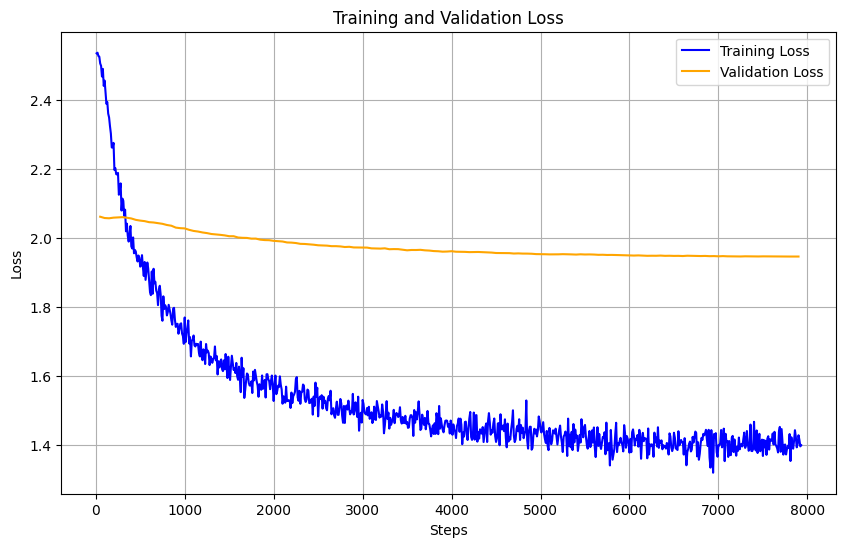

In [ ]:
# from matplotlib import pyplot as plt

# # Plot the losses
# plt.figure(figsize=(10, 6))
# plt.plot(train_steps, train_losses, label="Training Loss", color="blue")
# # plt.plot(train_steps, grad_norms, label="Grad Norms", color="yellow")
# plt.plot(eval_steps, eval_losses, label="Validation Loss", color="orange")
# plt.xlabel("Steps")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.grid()
# plt.show()